# Propagation d'incertitudes dans une chaîne de Markov

## Résumé 

Dans ce document, on présente comment simuler une chaîne de Markov à l'aide d'une fonction de saut. Cette chaîne de Markov est semblable à celle associée à un Piecewise Deterministic Markov Process (PDMP) utilisé en fiabilité dynamique. Ce document utilise une implémentation fondée sur le module otmarkov.

## Références

* Demgne, Jeanne Ady. Modélisation d’actifs industriels pour l’optimisation robuste de stratégies de maintenance. Thèse de doctorat. Pau, 2015.
* Davis, Mark HA. "Piecewise‐deterministic Markov processes: a general class of non‐diffusion stochastic models." Journal of the Royal Statistical Society: Series B (Methodological) 46.3 (1984): 353-376.

## Description

On considère une chaîne de Markov ainsi construite. 

L'état du système au début du n-ème saut est constitué 
* d'un vecteur aléatoire $\boldsymbol{U}_n$,
* d'un vecteur déterministe $\boldsymbol{v}_n$. 

Le vecteur aléatoire $\boldsymbol{U}_n$ est ici constitué de trois marginales indépendantes :
* $K_n$ de loi Gaussienne,
* $P_n$ de loi Gaussienne,
* $R_n$ de loi Weibull tronquée.

Le vecteur déterministe $\boldsymbol{v}_n$ est constitué d'une variable déterministe :

* $y_n\in\mathbb{R}$.

L'état déterministe initial est donné par l'équation 
$$
y_1 = 0.
$$

A chaque saut de la chaîne de Markov, nous générons une réalisation du vecteur aléatoire $\boldsymbol{U}_n$ et appliquons la fonction de transition $\boldsymbol{\Phi}$ pour connaître la valeur du vecteur déterministe $\boldsymbol{v}_{n+1}$. Dans notre application, on considère 3 sauts :

$$
m = 3.
$$

Dans cette chaîne de Markov, l'état à la fin du n-ème saut est déterminé par la fonction de transition $\Phi$ :

$$
\boldsymbol{v}_{n+1} = \boldsymbol{\Phi}(\boldsymbol{U}_n, \boldsymbol{v}_n),
$$
pour $n=1,...,m$. 

Dans notre application, la fonction de transition est définie par :

$$
\boldsymbol{\Phi}(\boldsymbol{U}_n, y_n) = y_n + \tau (1 - R_n) K_n P_n,
$$

où $\boldsymbol{U}_n = (K_n, P_n, R_n)\in\mathbb{R}^3$ et $\tau$ est une constante égale à 

$$
\tau = 12.
$$

Nous nous intéressons à la variable aléatoire $Y_4$, c'est à dire à la valeur de la variable $Y_n$ au terme des $m=3$ sauts. 

Nous considérons deux quantités d'intérêt :
* l'espérance de $Y_4$ : $\mathbb{E}(Y_4)$,
* la probabilité que $Y_4$ soit plus grande qu'un seuil donné : $\mathbb{P}(Y_4 > y_{lim})$.

Dans notre application, nous considérons le seuil limite :
$$
y_{lim}=14.
$$

In [1]:
import openturns as ot
import otmarkov

Fonction de transition
---

Fonction qui permet d'aller de l'état courant à l'état suivant.

In [2]:
def model(X):
    """
    The function which performs the step.

    The inputs are:
        * X[0] : K
        * X[1] : P
        * X[2] : R
        * X[3] : tau
        * X[4] : state

    The output is the new state.

    Parameters
    ----------
    X : ot.Point(5)
        The input of the model.

    Returns
    -------
    new_state : ot.Point(1)
        The new state.
    """
    X = ot.Point(X)
    K, P, R, tau, state = X
    new_state = state + tau * (1.0 - R) * K * P
    verbose = False  # Set to True to print intermediate messages.
    if verbose:
        print("X=", X, "New state=", new_state)
    return [new_state]

model_py = ot.PythonFunction(5, 1, model)

We first set tau as a parameter, because it is constant. 

In [3]:
tau = 10.0
reference_point = [tau]
indices = [3]
parametric_model = ot.ParametricFunction(model_py, indices, reference_point)
print(parametric_model)

ParametricEvaluation(class=PythonEvaluation name=OpenTURNSPythonFunction, parameters positions=[3], parameters=[x3 : 10], input positions=[0,1,2,4])


Given the random input and the state, the parametric model returns the new state.

In [4]:
K = 0.85
P = 2.0
R = 0.45
state = 0.0
X = [K, P, R, state]
new_state = parametric_model(X)
new_state

class=Point name=Unnamed dimension=1 values=[9.35]

The function just evaluated the following expression:

In [5]:
state + tau * (1.0 - R) * K * P

9.35

Create a parametric function from the model. 
The input is random, the parameter is the state, the output is the new state.

In [6]:
initial_state = [0.0]
indices = [3]
step_function = ot.ParametricFunction(parametric_model, indices, initial_state)

In [7]:
K = 0.85
P = 2.0
R = 0.45
X = [K, P, R]
new_state = step_function(X)
new_state

class=Point name=Unnamed dimension=1 values=[9.35]

## Distributions  des variables aléatoires K, P et R

In [8]:
dist_K = ot.Normal()
dist_P = ot.Normal()
dist_R = ot.WeibullMin()
Rmin = 1.0
dist_R = ot.TruncatedDistribution(dist_R, Rmin, ot.TruncatedDistribution.UPPER)

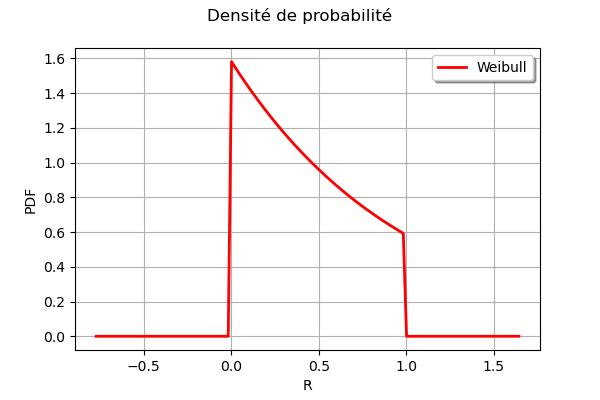

In [9]:
graph = dist_R.drawPDF()
graph.setLegends(["Weibull"])
graph.setTitle("Densité de probabilité")
graph.setXTitle("R")
graph

We now create the random vector.

In [10]:
distribution = ot.ComposedDistribution([dist_K, dist_P, dist_R])
print(distribution)

ComposedDistribution(Normal(mu = 0, sigma = 1), Normal(mu = 0, sigma = 1), TruncatedDistribution(WeibullMin(beta = 1, alpha = 1, gamma = 0), bounds = [0, 1]), IndependentCopula(dimension = 3))


## Perform several steps

We now show how the step function is used.

The state is the parameter of the function.

In [11]:
initial_state = [0.0]
step_function.setParameter(initial_state)

The input is the random vector.

In [12]:
X = distribution.getRealization()
print(X)

[0.608202,-1.26617,0.426266]


The output is the new state.

In [13]:
new_state = step_function(X)
print(new_state)

[-4.41826]


In order to perform several steps, we loop over the iterations. In the following, we perform 4 steps in the Markov chain.

In [14]:
initial_state = [0.0]
state = ot.Point(initial_state)
print("State=", state)
for i in range(4):
    step_function.setParameter(state)
    X = distribution.getRealization()
    state = step_function(X)
    print("State=", state)

State= [0]
State= [0.221412]
State= [-0.586886]
State= [2.9754]
State= [-25.6146]


In order to see how the state is passed as an input argument to the model, please set the `verbose` variable to `True` in the function. Notice, however, that this may print lots of messages if the sample is large.

## Create the Markov chain

In the following script, we create a Markov chain that simulates the process. This creates a `PythonRandomVector` which provides a `getSample` method.

In [15]:
initial_state = [0.0]

number_of_steps = 3

mc_random_vector = otmarkov.MarkovChainRandomVector(
    step_function, distribution, number_of_steps, initial_state
)
random_vector = ot.RandomVector(mc_random_vector)

In [16]:
outputSample = random_vector.getSample(10)
outputSample

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=10 dimension=1 data=[[-1.60571],[-4.07117],[1.18416],[-2.77013],[1.13406],[-1.75609],[0.666049],[-12.7858],[-15.9904],[-1.29037]]

## Estimation de la sortie moyenne

On souhaite estimer la moyenne de la sortie par un plan d'expériences de type Monte-Carlo simple. 

In [17]:
# Estime la sortie moyenne
sampleSize = 1000
outputSample = random_vector.getSample(sampleSize)
print("Sortie Moyenne = %f" % (outputSample.computeMean()[0]))

Sortie Moyenne = -0.384317


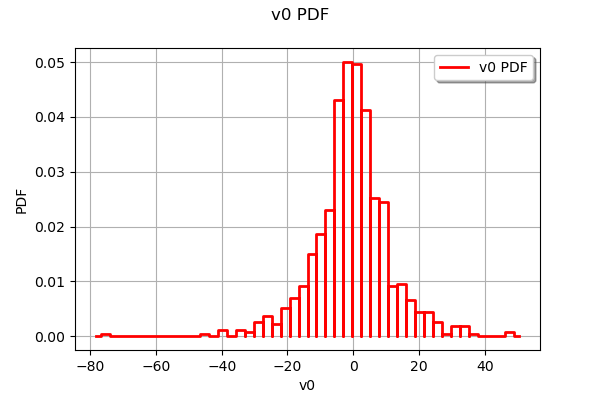

In [18]:
# Draw histogram
ot.HistogramFactory().build(outputSample).drawPDF()

Estimation de la probabilité de dépasser un seuil
---

On souhaite estimer la probabilité que la sortie dépasse un seuil par une méthode de Monte-Carlo simple.

We use the `MarkovChain` class. This provides a `getRandomVector` method, which is a `CompositeRandomVector`. This object is required by the `ThresholdEvent` class.

In [19]:
markov_chain = otmarkov.MarkovChain(
    step_function, distribution, number_of_steps, initial_state
)
composite_random_vector = markov_chain.getRandomVector()

In [20]:
composite_random_vector.getRealization()

class=Point name=Unnamed dimension=1 values=[4.19947]

In [21]:
composite_random_vector.getSample(10)

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=10 dimension=1 description=[y0] data=[[0.280642],[6.71381],[-0.776431],[-7.16177],[-2.20862],[-1.2143],[-4.24451],[2.53204],[6.05353],[-2.79038]]

In [22]:
Y_limite = 10.0
event = ot.ThresholdEvent(composite_random_vector, ot.Greater(), Y_limite)

In [23]:
# create a Monte Carlo algorithm
Nbsimu = 1000
experiment = ot.MonteCarloExperiment()
algo = ot.ProbabilitySimulationAlgorithm(event, experiment)
algo.setMaximumCoefficientOfVariation(0.05)
algo.setBlockSize(10)
algo.setMaximumOuterSampling(Nbsimu)
algo.run()

In [24]:
# retrieve results
result = algo.getResult()
probability = result.getProbabilityEstimate()
print("P(Y > Y_limite)=", probability)

P(Y > Y_limite)= 0.13558718861209987


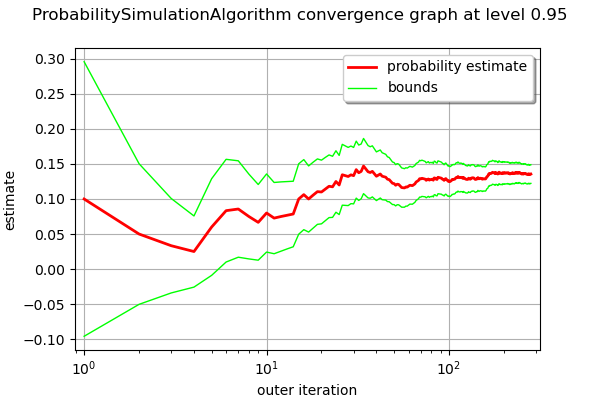

In [25]:
graph = algo.drawProbabilityConvergence()
graph.setLogScale(ot.GraphImplementation.LOGX)
graph

Estimation de la sortie moyenne - plans d'expériences
---
On souhaite estimer la moyenne de la sortie et expérimenter différents plan d'expériences : Monte-Carlo simple et séquence de Sobol'.

In [26]:
distribution = markov_chain.getInputDistribution()
input_dimension = distribution.getDimension()
input_dimension

9

In [27]:
function = markov_chain.getFunction()
function.getInputDimension()

9

In [28]:
Nbsimu = 1000
ot.RandomGenerator.SetSeed(1)
myDOE = ot.MonteCarloExperiment(distribution, Nbsimu)
mySample = myDOE.generate()
Y = function(mySample)

Calcul de la moyenne de la sortie

In [29]:
yMoyenne = Y.computeMean()[0]
print("Y moyenne : %f" % (yMoyenne))

Y moyenne : 0.587896


Pour utiliser une séquence à faible discrépance, il suffit de reprendre le script précédent avec le plan d'expérience suivant.

In [30]:
Nbsimu = 1000
sequence = ot.SobolSequence(input_dimension)
experiment = ot.LowDiscrepancyExperiment(sequence, distribution, Nbsimu)
experiment.setRandomize(True)
mySample = experiment.generate()

In [31]:
ot.RandomGenerator.SetSeed(1)
Y = function(mySample)

In [32]:
yMoyenne = Y.computeMean()[0]
print("Y moyenne : %f" % (yMoyenne))

Y moyenne : 0.066150
